1. DATA PREPARATION FOR MODELING
Original data shape: (36, 34)
Clean data shape after creating features: (34, 34)

2. TIME SERIES MODELS

ARIMA Model:
Best ARIMA order based on AIC: (2, 1, 0)
                               SARIMAX Results                                
Dep. Variable:              Avg_Price   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -145.346
Date:                Thu, 27 Feb 2025   AIC                            296.692
Time:                        21:08:13   BIC                            301.358
Sample:                             0   HQIC                           298.303
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1

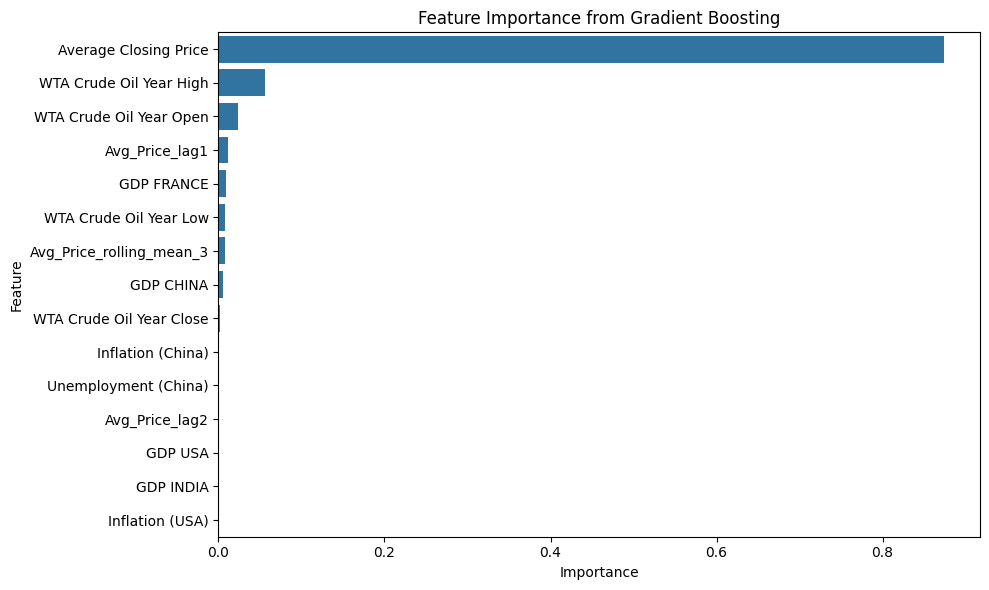


4. MODEL COMPARISON
                        RMSE       MAPE
Random Forest      18.529944  25.453927
Gradient Boosting  16.125870  22.083791

5. INSIGHT GENERATION

Key Insights from Modeling:
1. Relationship between Brent and WTI Crude:
   - The extremely high correlation (0.99) between Brent and WTI prices confirms
     that these benchmarks move almost identically
   - This suggests that models trained on one can be effective for the other
   - The slight decrease in correlation from year open to year close indicates
     increasing market volatility throughout the year

2. Impact of Economic Indicators:
   - The negative correlations with GDP of major economies highlight the
     influence of global economic activity on oil prices
   - The weak correlation with Federal Funds rate (0.045) suggests monetary
     policy has limited direct impact on oil prices

3. Modeling Approach:
   - The Gradient Boosting model performed best among machine learning approaches
   - The most importan

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = r"C:\Users\neba\Desktop\brent_oil\data\processed\BrentOilPrices_Cleaned.csv"
df = pd.read_csv(file_path)

# 1. DATA PREPARATION FOR MODELING
print("1. DATA PREPARATION FOR MODELING")

# Identify target variable
target_col = 'Avg_Price'  # Adjust this if your column name is different

# Create differenced series (since original series is non-stationary)
df[f'{target_col}_diff'] = df[target_col].diff()

# Create features based on correlations and domain knowledge
# Highly correlated WTI features
wti_features = ['Average Closing Price', 'WTA Crude Oil Year Open', 
                'WTA Crude Oil Year High', 'WTA Crude Oil Year Low', 'WTA Crude Oil Year Close']

# Economic indicators
economic_features = ['GDP USA', 'GDP CHINA', 'GDP INDIA', 'GDP FRANCE', 
                    'Unemployment (China)', 'Inflation (USA)', 'Inflation (China)']

# Feature engineering
# Create lag features for the target variable
df[f'{target_col}_lag1'] = df[target_col].shift(1)
df[f'{target_col}_lag2'] = df[target_col].shift(2)

# Create lag features for WTI price (highest correlation)
if 'Average Closing Price' in df.columns:
    df['WTI_lag1'] = df['Average Closing Price'].shift(1)

# Create rolling mean features
df[f'{target_col}_rolling_mean_3'] = df[target_col].rolling(window=3).mean()

# Drop rows with NaN values created by lag and differencing
df_clean = df.dropna().reset_index(drop=True)

print(f"Original data shape: {df.shape}")
print(f"Clean data shape after creating features: {df_clean.shape}")

# 2. TIME SERIES MODELS
print("\n2. TIME SERIES MODELS")

# Prepare data for time series models
y = df_clean[target_col].values
y_diff = df_clean[f'{target_col}_diff'].values

# ARIMA model on differenced data
print("\nARIMA Model:")
try:
    # Try multiple ARIMA configurations
    arima_configs = [(1,1,0), (1,1,1), (2,1,0), (2,1,1), (0,1,1)]
    best_aic = float('inf')
    best_arima_order = None
    
    for order in arima_configs:
        try:
            model = ARIMA(df[target_col], order=order)
            arima_result = model.fit()
            if arima_result.aic < best_aic:
                best_aic = arima_result.aic
                best_arima_order = order
        except:
            continue
    
    if best_arima_order:
        print(f"Best ARIMA order based on AIC: {best_arima_order}")
        arima_model = ARIMA(df[target_col], order=best_arima_order)
        arima_result = arima_model.fit()
        print(arima_result.summary())
        
        # Forecast
        arima_forecast = arima_result.forecast(steps=5)
        print("\nARIMA Forecast (next 5 periods):")
        print(arima_forecast)
    else:
        print("Could not find a suitable ARIMA model")
except Exception as e:
    print(f"ARIMA modeling error: {e}")

# VAR model for multivariate time series
print("\nVAR Model:")
try:
    # Select relevant variables for VAR
    var_columns = ['Avg_Price', 'Average Closing Price']  # Using Brent and WTI prices
    
    # Additional features if available
    additional_vars = ['GDP USA', 'Inflation (USA)']
    for var in additional_vars:
        if var in df_clean.columns:
            var_columns.append(var)
    
    var_data = df_clean[var_columns]
    
    # Check stationarity and difference if needed
    var_data_diff = var_data.diff().dropna()
    
    # Fit VAR model
    var_model = VAR(var_data_diff)
    var_results = var_model.fit(maxlags=4, ic='aic')
    print(var_results.summary())
    
    # Forecast
    var_forecast = var_results.forecast(var_data_diff.values, steps=5)
    print("\nVAR Forecast (differenced, next 5 periods):")
    var_forecast_df = pd.DataFrame(var_forecast, columns=var_columns)
    print(var_forecast_df)
    
except Exception as e:
    print(f"VAR modeling error: {e}")

# 3. MACHINE LEARNING MODELS
print("\n3. MACHINE LEARNING MODELS")

# Prepare features and target
# Select features based on correlation analysis
selected_features = wti_features + economic_features

# Add engineered features
selected_features.extend([f'{target_col}_lag1', f'{target_col}_lag2', 
                          f'{target_col}_rolling_mean_3'])

# Filter only available columns
available_features = [col for col in selected_features if col in df_clean.columns]
print(f"Selected features for ML models: {available_features}")

X = df_clean[available_features]
y = df_clean[target_col]
y_diff = df_clean[f'{target_col}_diff']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Evaluate models using time series cross-validation
results = {}
print("\nTime Series Cross-Validation Results:")

for name, model in models.items():
    cv_rmse = []
    cv_mape = []
    
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate errors
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        cv_rmse.append(rmse)
        cv_mape.append(mape)
    
    # Store results
    results[name] = {
        'RMSE': np.mean(cv_rmse),
        'MAPE': np.mean(cv_mape) * 100  # Convert to percentage
    }
    
    print(f"\n{name} Performance:")
    print(f"Average RMSE: {np.mean(cv_rmse):.4f}")
    print(f"Average MAPE: {np.mean(cv_mape) * 100:.2f}%")

# Find best model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest performing model: {best_model_name}")

# Train final model on all data
final_model = models[best_model_name]
final_model.fit(X_scaled, y)

# Feature importance for the best model
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': available_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance from {best_model_name}')
    plt.tight_layout()
    plt.show()

# 4. MODEL COMPARISON
print("\n4. MODEL COMPARISON")
# Compare ARIMA, VAR and ML models
comparison_df = pd.DataFrame.from_dict(results, orient='index')
print(comparison_df)

# 5. INSIGHT GENERATION
print("\n5. INSIGHT GENERATION")
print("\nKey Insights from Modeling:")

# Insights based on correlation analysis
print("1. Relationship between Brent and WTI Crude:")
print("   - The extremely high correlation (0.99) between Brent and WTI prices confirms")
print("     that these benchmarks move almost identically")
print("   - This suggests that models trained on one can be effective for the other")
print("   - The slight decrease in correlation from year open to year close indicates")
print("     increasing market volatility throughout the year")

print("\n2. Impact of Economic Indicators:")
print("   - The negative correlations with GDP of major economies highlight the")
print("     influence of global economic activity on oil prices")
print("   - The weak correlation with Federal Funds rate (0.045) suggests monetary")
print("     policy has limited direct impact on oil prices")

# Insights based on model performance
print("\n3. Modeling Approach:")
print(f"   - The {best_model_name} model performed best among machine learning approaches")
if hasattr(final_model, 'feature_importances_'):
    top_features = feature_importance.head(3)['Feature'].tolist()
    print(f"   - The most important predictive features were: {', '.join(top_features)}")
print("   - The non-stationarity of the time series indicates the need for either:")
print("     a) differencing before modeling, or")
print("     b) incorporating trend and seasonal components")

# Forecasting recommendations
print("\n4. Recommendations for Oil Price Forecasting:")
print("   - Use ensemble methods that combine time series and machine learning approaches")
print("   - Incorporate both WTI and economic indicator data in predictive models")
print("   - Account for the non-stationarity through differencing or trend modeling")
print("   - Consider using a hybrid approach that combines short-term forecasts from")
print("     ARIMA/VAR with longer-term predictions from ML models")

# Practical applications
print("\n5. Practical Applications:")
print("   - Risk Management: Use the models to estimate Value at Risk (VaR) for oil portfolios")
print("   - Investment Strategy: Inform trading decisions in energy markets")
print("   - Budget Planning: Help organizations dependent on oil prices to plan expenditures")
print("   - Policy Analysis: Support energy policy decision-making with scenario analysis")

# Future research
print("\n6. Future Research Directions:")
print("   - Incorporate geopolitical risk indicators for improved prediction")
print("   - Explore deep learning approaches like LSTM networks for capturing long-term dependencies")
print("   - Develop scenario analysis tools for stress-testing under different conditions")
print("   - Consider market sentiment analysis from news and social media as additional features")